# Pylops-distributed - wave equation processing

### Author: M.Ravasi

This notebook extends the standard Multi-dimensional convolution (MDC) and Multi-dimensional deconvolution (MDD) algorithms in PyLops to distibuted computing with dask

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *

from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
n_workers = 4
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=1,
                                               n_workers=n_workers)
client

Client Scheduler: inproc://10.0.0.37/4324/1 Dashboard: http://localhost:52753/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


# Multi-dimensional convolution (MDC)

The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ y(s,v,f) = \int_S R(s,v,f) x(r,v,f) dr$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F}^H  \mathbf{R} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{R}$ is multi-dimensional convolution kernel espressed in the equation above.

Let's start considering a single virtual source

In [3]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':60,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':400,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1]
theta_m = [0]
phi_m   = [0]
amp_m   = [1.]

t0_G    = [0.05,0.2,0.3]
theta_G = [0,0,0]
phi_G   = [0,0,0]
amp_G   = [1.,0.6,2.]


# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  linear2d(x,t,v,t0_m,theta_m,amp_m,wav)

# Generate operator
G,Gwav = linear3d(x,y,t,v,t0_G,theta_G,phi_G,amp_G,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)), m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

In [4]:
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]
Gwav_fft = Gwav_fft.transpose(2,0,1)

Gwav_fft_d = da.from_array(Gwav_fft, chunks=(par['nfmax'] // n_workers, par['ny'], par['nx']))
Gwav_fft_d

dask.array<array, shape=(210, 100, 60), dtype=complex128, chunksize=(52, 100, 60)>

In [5]:
# PyLops
MDCop = \
    pylops.waveeqprocessing.MDC(Gwav_fft, nt=2*par['nt']-1, 
                                nv=1, dt=par['dt'], dr=par['dx'], 
                                twosided=True, transpose=False)

dottest(MDCop, (2*par['nt']-1) *par['ny'], 
        (2*par['nt']-1) *par['nx'], complexflag=3, verb=True)

Dot test passed, v^T(Opu)=880.243329 - u^T(Op^Tv)=880.243329


True

In [6]:
# PyLops-dist
dMDCop = \
    pylops_distributed.waveeqprocessing.MDC(Gwav_fft_d, nt=2*par['nt']-1, 
                                            nv=1, dt=par['dt'], dr=par['dx'], 
                                            twosided=True)
ddottest(dMDCop, (2*par['nt']-1) *par['ny'], 
         (2*par['nt']-1) * par['nx'], 
         chunks=(dMDCop.shape[0], dMDCop.shape[1]),
         complexflag=3, verb=True);

Dot test passed, v^T(Opu)=177.592316 - u^T(Op^Tv)=177.592316


Forward

In [7]:
d = MDCop*m.T.ravel()
d = d.reshape(2*par['nt']-1, par['ny'])

In [8]:
dd = dMDCop * (da.from_array(m.T, chunks=(2*par['nt']-1, par['nx']))).ravel()
dd = dd.reshape(2*par['nt']-1, par['ny'])
dd

dask.array<reshape, shape=(799, 100), dtype=float64, chunksize=(799, 100)>

Adjoint

In [9]:
madj = MDCop.H*d.ravel()
madj = madj.reshape(2*par['nt']-1, par['nx'])

In [10]:
dmadj = dMDCop.H*dd.ravel()
dmadj = dmadj.reshape(2*par['nt']-1, par['nx'])

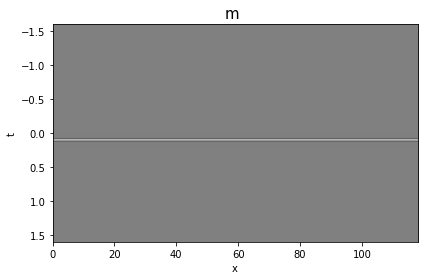

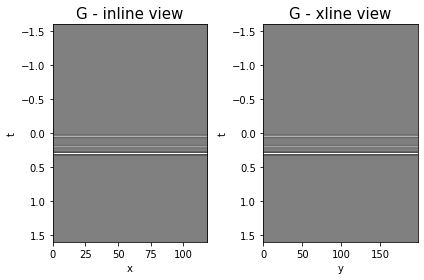

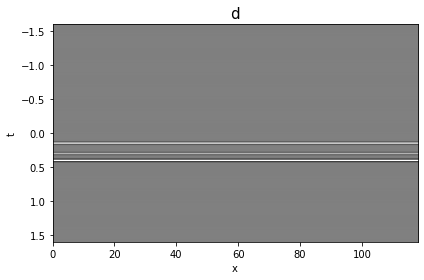

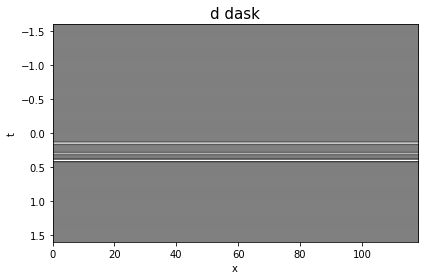

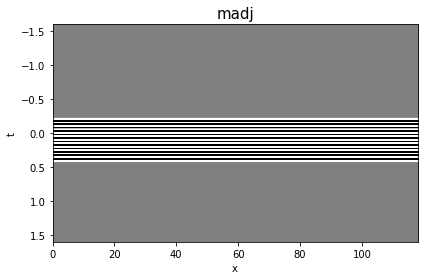

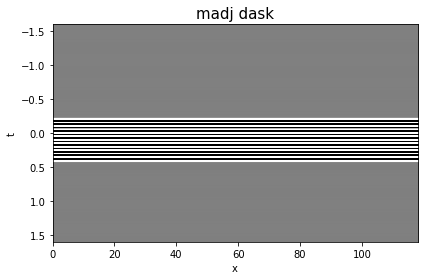

In [11]:
# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()

plt.figure()
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T, aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T, aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure()
plt.imshow(d, aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.figure()
plt.imshow(dd.compute(), aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d dask', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.imshow(madj, aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('madj', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.figure()
plt.imshow(dmadj.compute(), aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('madj dask', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

In [12]:
np.allclose(d, dd.compute())

True

In [13]:
np.allclose(madj, dmadj.compute())

True

## Application 1: Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{d}= \mathbf{D} \mathbf{m}$$

or, equivalently, by means of its normal equation

$$\mathbf{m}= (\mathbf{D}^H\mathbf{D})^{-1} \mathbf{D}^H\mathbf{d}$$

where $\mathbf{D}^H\mathbf{D}$ is generally referred to as blurring operator or PSF.

### Single virtual source

Let's take from where we left and invert our MDC operator

In [14]:
madj = MDCop.H*d.flatten()
minv, istop, itn, r1norm, r2norm = \
    lsqr(MDCop, d.flatten(), damp=1e-10, iter_lim=10, show=1)[0:5]

madj = madj.reshape(2*par['nt']-1, par['nx'])
minv = minv.reshape(2*par['nt']-1, par['nx'])

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    79900 rows  and    47940 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.075e+02  6.075e+02    1.0e+00  3.5e-01
     1  2.05408e-11   3.382e+02  3.382e+02    5.6e-01  7.1e-01   2.6e+02  1.0e+00
     2  5.35323e-11   1.981e+02  1.981e+02    3.3e-01  3.7e-01   3.6e+02  2.3e+00
     3  9.55186e-11   1.457e+02  1.457e+02    2.4e-01  3.1e-01   4.2e+02  3.6e+00
     4  1.52563e-10   1.086e+02  1.086e+02    1.8e-01  2.3e-01   4.9e+02  5.2e+00
     5 -3.91262e-09   8.804e+01  8.804e+01    1.4e-01  2.0e-01   5.4e+02  6.8e+00
     6 -1.73238e-05   7.267e+01  7.267e+01    1.2e-01  1.5e-01   5.9e+02  8.6e+00
     7  3.59669e-05   6.147e+01  6.147e+01    1.0e-01  1.2e-01   6.3e+02  1.1e+01
     8  9.59186e-04   5.281e

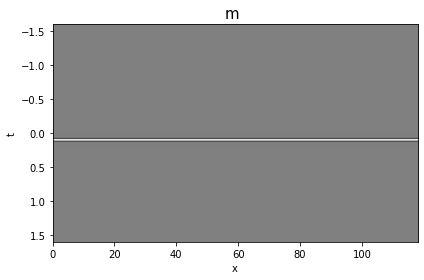

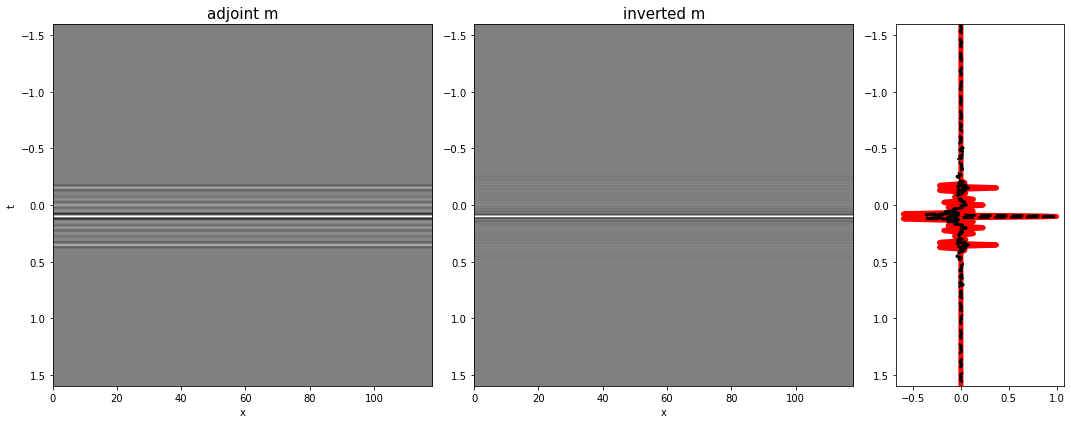

In [15]:
# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(par['nx']/2)]/np.abs(madj[:, int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(par['nx']/2)]/np.abs(minv[:, int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

We solve now the same problem with distributed operators

In [16]:
dMDCop = \
    pylops_distributed.waveeqprocessing.MDC(Gwav_fft_d, nt=2*par['nt']-1, 
                                            nv=1, dt=par['dt'], dr=par['dx'], 
                                            twosided=True, todask=(True, True))
ddottest(dMDCop, (2*par['nt']-1) *par['ny'], 
         (2*par['nt']-1) * par['nx'], 
         chunks=(dMDCop.shape[0], dMDCop.shape[1]),
         complexflag=3, verb=True);

Dot test passed, v^T(Opu)=-0.616991 - u^T(Op^Tv)=-0.616991


In [17]:
dmadj = dMDCop.H*dd.flatten()
dmadj = dmadj.reshape(2*par['nt']-1, par['nx'])
dmadj = dmadj.compute()

In [18]:
dMDCop.rmatvec(np.ones(79900))

dask.array<reshape, shape=(47940,), dtype=float64, chunksize=(47940,)>

In [19]:
#dminv = dcg(dMDCop.H * dMDCop, dMDCop.H * dd.ravel(), 
#            niter=10, compute=False)
dminv = dcgls(dMDCop, dd.ravel(), niter=10, compute=False)

dminv = dminv.reshape(2*par['nt']-1, par['nx'])
print('dminv', dminv)
dminv = dminv.compute()

dminv dask.array<reshape, shape=(799, 60), dtype=float64, chunksize=(799, 60)>


In [20]:
#dminv = dcg(dMDCop.H * dMDCop, dMDCop.H * dd.ravel(), 
#            niter=10, compute=True)
dminv = dcgls(dMDCop, dd.ravel(), niter=10, compute=True)

dminv = dminv.reshape(2*par['nt']-1, par['nx'])

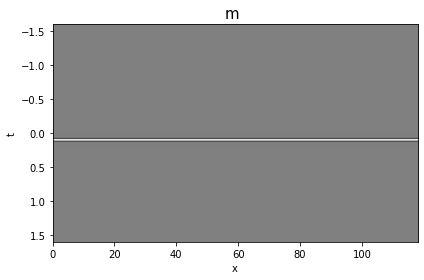

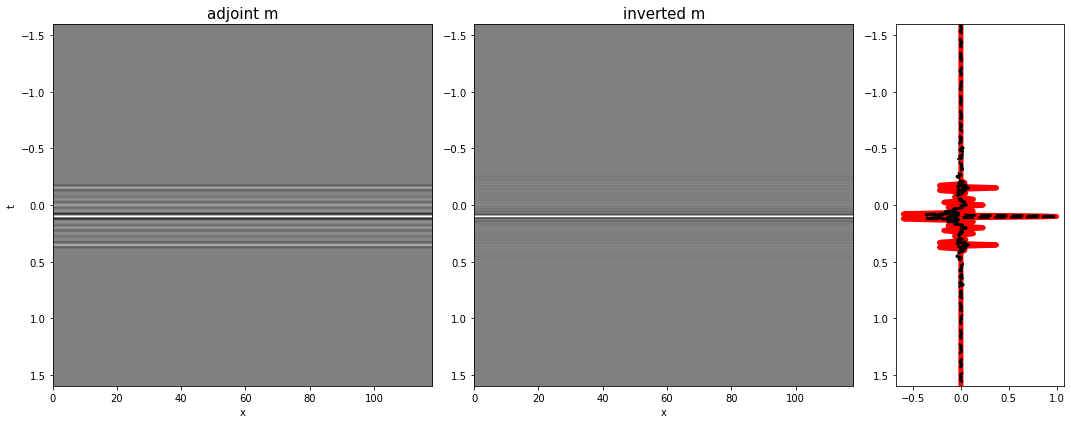

In [21]:
# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(dmadj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-dmadj.max(), vmax=dmadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(dminv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-dminv.max(), vmax=dminv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(dmadj[:, int(par['nx']/2)]/np.abs(dmadj[:, int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(dminv[:, int(par['nx']/2)]/np.abs(dminv[:, int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

In [ ]:
%timeit -n 2 -r 2 dcg(dMDCop.H * dMDCop, dMDCop.H * dd.ravel(), niter=5, compute=False).compute()
%timeit -n 2 -r 2 dcg(dMDCop.H * dMDCop, dMDCop.H * dd.ravel(), niter=5, compute=True)

3.44 s ± 46.5 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
